### Survival Analysis

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [11]:
import sys
sys.path.append('../..')
import warnings
def warn(message, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.style.use('seaborn-paper')
from lifelines import KaplanMeierFitter
from diabetes_onset import survival_diabetes

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from diabetes_onset_plotter import survival_fit_res, make_results


#### Get the following datasets from running ```diabetes_surv_propens5.ipynb```

In [3]:
%%time
p = '../tempNN/'
treated0 = pd.read_pickle(p+'treated0.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

control0 = pd.read_pickle(p+'match0.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)


CPU times: user 210 ms, sys: 68.8 ms, total: 279 ms
Wall time: 295 ms


In [4]:
%%time
surv1 = treated0.groupby('PERS_ID').apply(survival_diabetes).reset_index(drop = True)


CPU times: user 2.23 s, sys: 10.5 ms, total: 2.24 s
Wall time: 2.24 s


In [5]:
%%time
surv3 = control0.groupby('PERS_ID').apply(survival_diabetes).reset_index(drop = True)


CPU times: user 8.96 s, sys: 41.9 ms, total: 9.01 s
Wall time: 9.01 s


In [6]:
%%time
#surv5 = random.groupby('PERS_ID').apply(survival_diabetes).reset_index(drop = True)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs


<div style="background:Aliceblue"> <h3>Fit Kaplan Meier Curves for Survival Analysis </br>
$P(T > t) = \prod_{t_i <t}\frac{n_i-d_i}{n_i}$ </br>
$n_i$: Remaining population before time $t_i$ </br>
$d_i$: Events (Diabetes Onsets) at time $t_i$
</h3>
</div>

In [7]:
from lifelines import CoxPHFitter 
from lifelines import WeibullFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts, rmst_plot
from lifelines.utils import restricted_mean_survival_time



In [8]:
surv1['Treatment'] = 1
surv3['Treatment'] = 0
surv_all = pd.concat((surv1, surv3), axis = 0)

In [15]:
filter_cols =  ['AGE_AT_MIDMONTH', 'MBR_GNDR', 'ALLOW_AMT','CC_TOBACCO',  'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT','LOB', 'T', 'E']

log_normalize = ['ALLOW_AMT']
normalize = ['AGE_AT_MIDMONTH', 'CC_DX_CNT']

model_args ={}# {"penalizer":0.001, 'alpha': 0.01}
fitted = survival_fit_res( ['Treated', 'Controls'],  surv1, surv3,
                          model = CoxPHFitter, model_type ='Cox',
                          model_args = model_args, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)



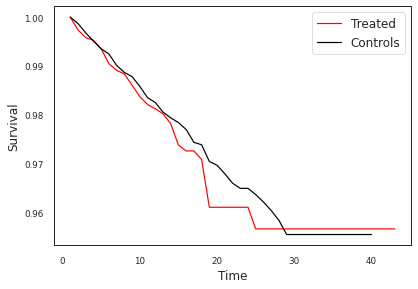

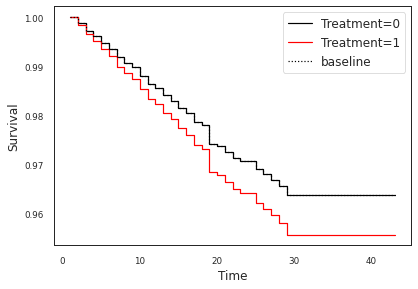

In [17]:
path_tabs = '../res/tabs/'
path_figs = '../res/figs/'
filter_cols2 =  ['AGE_AT_MIDMONTH', 'MBR_GNDR', 'ALLOW_AMT','CC_TOBACCO', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT','LOB', 'T', 'E', 'Treatment']

summary_names =  ['Age','Gender', 'Total Cost',  'Tobacco use',  'Obesity', 
            'Hypertension', 'Hypothyroid', 'Disease Count',  'Line of Bussiness', 'Treatment']

model_args ={}# {"penalizer":0.001, 'alpha': 0.05}

lrsumm, ax1, ax2, summ = make_results(fitted, surv1, surv3, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, outcome = 'Diabetes', 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize)

### OLD RESULTS FROM HERE

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (15,9))

kmf = KaplanMeierFitter()

kmf.fit(surv1['T'], event_observed=surv1.E, label="Treated")
kmf.plot_survival_function(ax=ax,ci_show=False)


kmf.fit(surv3['T'], event_observed=surv3.E, label="Controls")
kmf.plot_survival_function(ax=ax,ci_show=False)

#ax.set_xlim(0, 25)
#ax.set_ylim(0.94, 1)
fig.show()

In [ ]:
results = logrank_test(surv1['T'], surv3['T'], event_observed_A=surv1.E, event_observed_B=surv3.E)
results.print_summary()

### Cox Proportional Hazards Model: Models the hazard function $h(t|x)$  
$h(t|x) = h_0(t)f(x)$  
where $h_0$ is the baseline hazard function depending only on time $t$  
and $f(x)$ modifies the hazard function dependent on a subject's covariates

In [ ]:

columns_to_match = ['AGE_AT_MIDMONTH', 'ALLOW_AMT','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT','LOB', 'T', 'E']
surv11 = surv1.loc[:,columns_to_match]
surv31 = surv3.loc[:,columns_to_match]

columns_to_normalize = ['AGE_AT_MIDMONTH', 'ALLOW_AMT']
surv11[columns_to_normalize] = MinMaxScaler().fit_transform(surv11[columns_to_normalize].values)
surv31[columns_to_normalize] = MinMaxScaler().fit_transform(surv31[columns_to_normalize].values)


cpx1 = CoxPHFitter().fit(surv11, duration_col = 'T', event_col = 'E', step_size = 0.1, show_progress=True)
cpx3 = CoxPHFitter().fit(surv31, duration_col = 'T', event_col = 'E', step_size = 0.1, show_progress=True)


In [ ]:
fig, ax = plt.subplots(1,1, figsize = (15,9))

ax = cpx1.baseline_survival_.plot(ax = ax)
cpx3.baseline_survival_.plot(ax = ax)
ax.legend(['Treated', 'Controls'])
plt.show()

### Coefficient Plot

### Treated

In [ ]:
cols = ['AGE_AT_MIDMONTH', 'ALLOW_AMT','CC_TOBACCO', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'LOB']
cpx1.plot(columns = cols)
plt.show()

### Controls

In [ ]:
cpx3.params_

In [ ]:
cpx3.print_summary()

In [ ]:
cpx3.plot(columns = ['AGE_AT_MIDMONTH', 'ALLOW_AMT','CC_TOBACCO', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'LOB'])
plt.show()

## 1. Matched Controls plus Treated  
<h3><span style="color:red">to study the treatment effect</span></h3>

In [ ]:
surv1['Treatment'] = 1

surv3['Treatment'] = 0

columns_to_match = ['AGE_AT_MIDMONTH', 'ALLOW_AMT','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'LOB', 'T', 'E', 'Treatment']

columns_to_normalize = ['AGE_AT_MIDMONTH', 'ALLOW_AMT']


alltogether = pd.concat((surv1,  surv3), axis = 0, ignore_index = True )[columns_to_match]
alltogether[columns_to_normalize] = MinMaxScaler().fit_transform(alltogether[columns_to_normalize].values)

cpxAll = CoxPHFitter().fit(alltogether, duration_col = 'T', event_col = 'E', step_size = 0.1, show_progress=True)

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (15,9))

ax = cpxAll.baseline_survival_.plot(ax = ax)

ax.legend([ 'All'])
plt.show()

### All

In [ ]:
cols = ['AGE_AT_MIDMONTH', 'CC_TOBACCO', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'Treatment', 'LOB']
cpxAll.plot(columns = cols)
plt.show()

### All

In [ ]:
cpxAll.print_summary()

In [ ]:
cpxAll.params_

In [ ]:
import seaborn as sns

alltogether = pd.concat((surv1,  surv3), axis = 0, ignore_index = True )[columns_to_match]
bins = np.arange(10,115, 15)
ind = np.digitize(alltogether['AGE_AT_MIDMONTH'], bins)
data_new  = alltogether.copy()
data_new['ind'] = ind

In [ ]:
sns.boxplot(x = 'ind', y = 'T', data = data_new[data_new.E == 1])